In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/harcascade/haarcascades/haarcascade_upperbody.xml
/kaggle/input/harcascade/haarcascades/haarcascade_eye.xml
/kaggle/input/harcascade/haarcascades/haarcascade_licence_plate_rus_16stages.xml
/kaggle/input/harcascade/haarcascades/haarcascade_frontalface_default.xml
/kaggle/input/harcascade/haarcascades/haarcascade_frontalcatface_extended.xml
/kaggle/input/harcascade/haarcascades/haarcascade_eye_tree_eyeglasses.xml
/kaggle/input/harcascade/haarcascades/haarcascade_fullbody.xml
/kaggle/input/harcascade/haarcascades/haarcascade_lowerbody.xml
/kaggle/input/harcascade/haarcascades/haarcascade_righteye_2splits.xml
/kaggle/input/harcascade/haarcascades/haarcascade_frontalface_alt_tree.xml
/kaggle/input/harcascade/haarcascades/haarcascade_frontalcatface.xml
/kaggle/input/harcascade/haarcascades/haarcascade_frontalface_alt.xml
/kaggle/input/harcascade/haarcascades/haarcascade_russian_plate_number.xml
/kaggle/input/harcascade/haarcascades/haarcascade_smile.xml
/kaggle/input/harcascade

In [2]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt

PREPROCESSING

we identify a person using a face. An image might contain multiple faces, 
also the face can be obstructed and not clear. The first step in our pre-processing pipeline 
is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are 
detected then only we keep that image otherwise discard it

In [3]:
img = cv2.imread('/kaggle/input/images-dataset/images_dataset/maria_sharapova/1368843.jpg')
img.shape

(1000, 1600, 3)

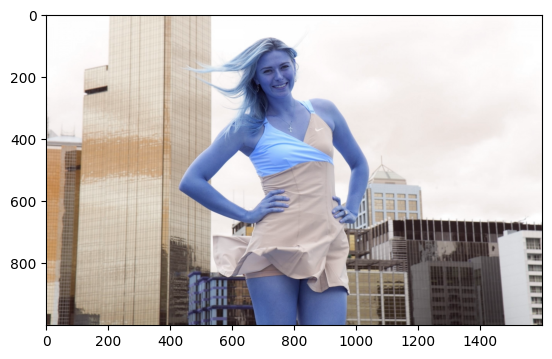

In [4]:
plt.imshow(img)

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1000, 1600)

In [6]:
gray

array([[255, 254, 255, ..., 253, 253, 253],
       [255, 255, 254, ..., 254, 254, 254],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [ 56,  55,  56, ..., 100, 100, 106],
       [ 72,  72,  71, ...,  84,  86,  91],
       [112, 112, 111, ...,  80,  83,  88]], dtype=uint8)

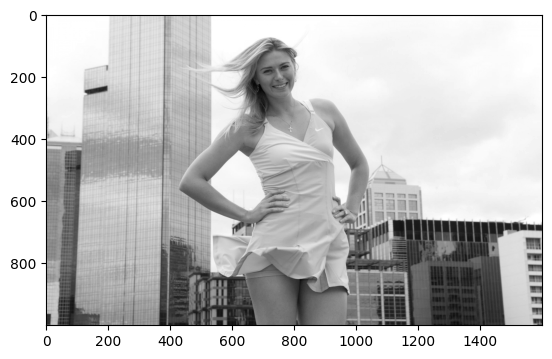

In [7]:
plt.imshow(gray, cmap='gray')

In [8]:
face_cascade = cv2.CascadeClassifier('/kaggle/input/harcascade/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/kaggle/input/harcascade/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[677, 123, 135, 135]], dtype=int32)

In [9]:
(x,y,w,h) = faces[0]
x,y,w,h

(677, 123, 135, 135)

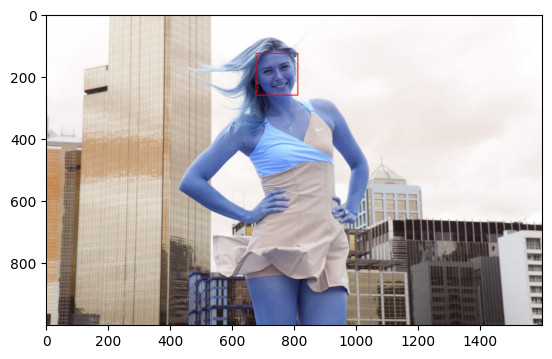

In [10]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

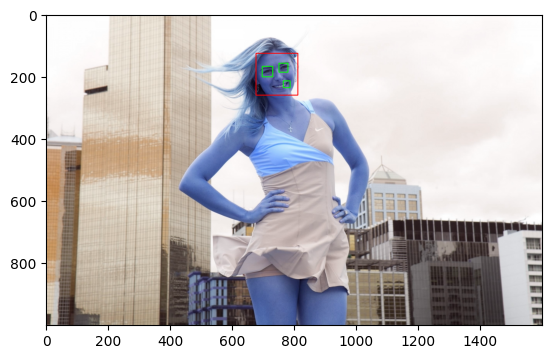

In [11]:

face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
roi_gray = gray[y:y+h, x:x+w]
roi_color = face_img[y:y+h, x:x+w]
eyes = eye_cascade.detectMultiScale(roi_gray)
for (ex,ey,ew,eh) in eyes:
    cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    cv2.rectangle(roi_gray,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        
plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

cropped facial image

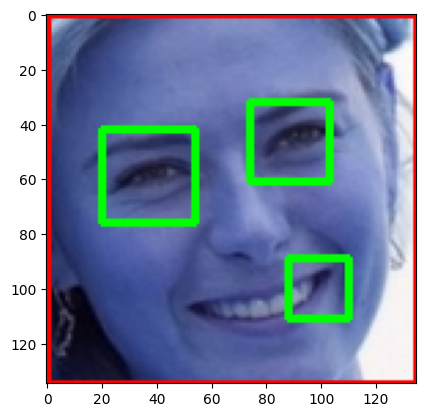

In [12]:
plt.imshow(roi_color)

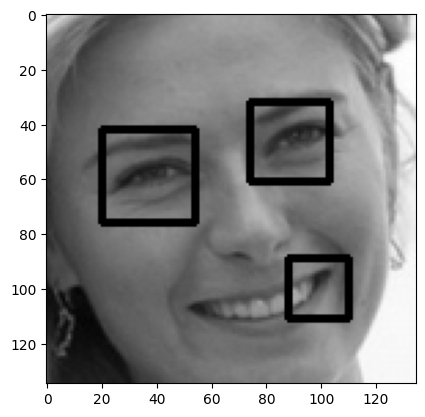

In [13]:
plt.imshow(roi_gray, cmap='gray')

In [14]:
roi_color.shape

(135, 135, 3)

USING WALVET TRANSFORM TO EXTRACT FEATURES FROM IMAGE

WAVELET TRANSFORM

In [15]:
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [16]:
cropped_img=np.array(roi_color)

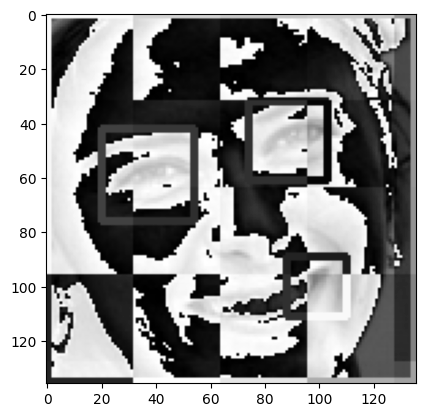

In [17]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

wavelet transformed image gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

In [18]:
im_har

array([[250, 250, 250, ..., 156, 156, 156],
       [250, 250, 250, ..., 156, 156, 156],
       [250, 250,  85, ...,  45, 156, 156],
       ...,
       [ 37,  37, 251, ...,  74, 161, 161],
       [ 37,  37,  37, ..., 161, 161, 161],
       [ 37,  37,  37, ..., 161, 161, 161]], dtype=uint8)

 If eyes >=2, then save and crop the face region

In [19]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

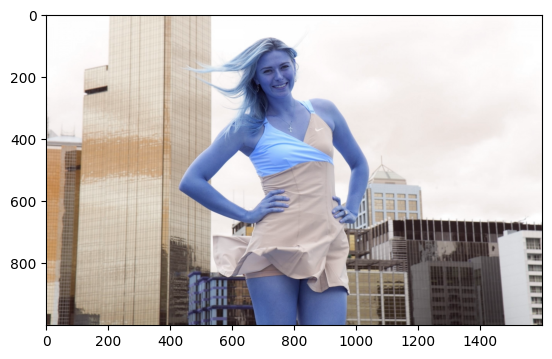

In [20]:
image1 = cv2.imread('/kaggle/input/images-dataset/images_dataset/maria_sharapova/1368843.jpg')
plt.imshow(image1)

array([[[204, 221, 240],
        [199, 215, 232],
        [180, 197, 216],
        ...,
        [177, 195, 218],
        [213, 223, 240],
        [231, 238, 247]],

       [[189, 209, 227],
        [176, 195, 216],
        [150, 171, 193],
        ...,
        [165, 187, 212],
        [209, 222, 238],
        [229, 236, 245]],

       [[163, 186, 208],
        [145, 167, 192],
        [149, 172, 198],
        ...,
        [166, 189, 215],
        [210, 224, 242],
        [229, 238, 248]],

       ...,

       [[ 49,  61,  97],
        [ 32,  41,  78],
        [ 22,  31,  65],
        ...,
        [248, 244, 243],
        [249, 244, 245],
        [250, 245, 246]],

       [[ 49,  61,  97],
        [ 34,  43,  80],
        [ 23,  32,  66],
        ...,
        [249, 245, 244],
        [249, 245, 244],
        [249, 245, 244]],

       [[ 47,  56,  93],
        [ 34,  43,  80],
        [ 25,  33,  70],
        ...,
        [249, 245, 244],
        [249, 245, 244],
        [250, 246, 245]]

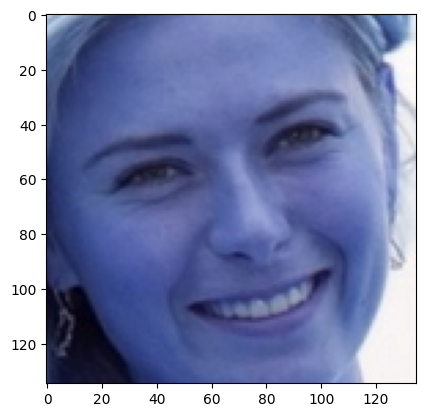

In [21]:
detect=get_cropped_image_if_2_eyes('/kaggle/input/images-dataset/images_dataset/maria_sharapova/1368843.jpg')
plt.imshow(detect)
detect

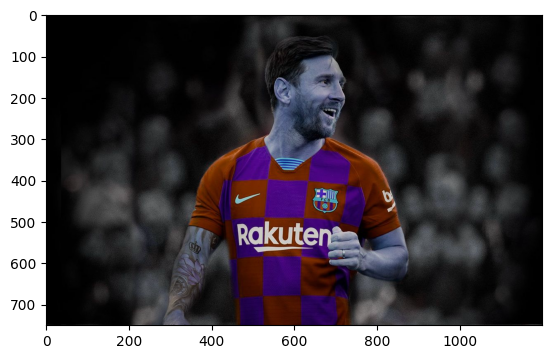

In [22]:
image2=cv2.imread('/kaggle/input/images-dataset/images_dataset/lionel_messi/10_MESSI_JUGADORS-WEB.jpg')
plt.imshow(image2)

In [23]:
detect=get_cropped_image_if_2_eyes('/kaggle/input/images-dataset/images_dataset/lionel_messi/10_MESSI_JUGADORS-WEB.jpg')
detect

here since messi face in not clear only 1 eyes is visible so detect does not return anything

We dont use images which do not have eyes greater than or equal to 2 for training

Now we need to go through all images in dataset folder and create cropped images for them. we will create cropped images folder now which contains all celebrities cropeed images

In [24]:
#shutil.rmtree("/kaggle/working/cropped")

In [25]:
path_to_data = "/kaggle/input/images-dataset/images_dataset/"
path_to_cr_data = "/kaggle/working/cropped/"

In [26]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
img_dirs

['/kaggle/input/images-dataset/images_dataset/roger_federer',
 '/kaggle/input/images-dataset/images_dataset/serena_williams',
 '/kaggle/input/images-dataset/images_dataset/lionel_messi',
 '/kaggle/input/images-dataset/images_dataset/virat_kohli',
 '/kaggle/input/images-dataset/images_dataset/maria_sharapova']

In [27]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [28]:
cropped_image_dirs = []

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            count += 1

Generating cropped images in folder:  /kaggle/working/cropped/roger_federer
Generating cropped images in folder:  /kaggle/working/cropped/serena_williams
Generating cropped images in folder:  /kaggle/working/cropped/lionel_messi
Generating cropped images in folder:  /kaggle/working/cropped/virat_kohli
Generating cropped images in folder:  /kaggle/working/cropped/maria_sharapova


Now we have cropped folder under datasets folder that contains cropped images

we need to to now manually delete some images which are not relevant

In [29]:
cropped_image_dirs


['/kaggle/working/cropped/roger_federer',
 '/kaggle/working/cropped/serena_williams',
 '/kaggle/working/cropped/lionel_messi',
 '/kaggle/working/cropped/virat_kohli',
 '/kaggle/working/cropped/maria_sharapova']

In [30]:
shutil.rmtree("/kaggle/working/cropped")

i have manually deleted some unwanted cropped images and uplod the updated croped folder in kaggle dataset 

In [31]:
!cp -r "../input/cropped/cropped" ./ #here i m replacing the old cropeed foler with updated cropped folder

In [32]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'roger_federer': ['/kaggle/working/cropped/roger_federer/roger_federer3.png',
  '/kaggle/working/cropped/roger_federer/roger_federer20.png',
  '/kaggle/working/cropped/roger_federer/roger_federer25.png',
  '/kaggle/working/cropped/roger_federer/roger_federer29.png',
  '/kaggle/working/cropped/roger_federer/roger_federer19.png',
  '/kaggle/working/cropped/roger_federer/roger_federer4.png',
  '/kaggle/working/cropped/roger_federer/roger_federer13.png',
  '/kaggle/working/cropped/roger_federer/roger_federer14.png',
  '/kaggle/working/cropped/roger_federer/roger_federer5.png',
  '/kaggle/working/cropped/roger_federer/roger_federer1.png',
  '/kaggle/working/cropped/roger_federer/roger_federer23.png',
  '/kaggle/working/cropped/roger_federer/roger_federer18.png',
  '/kaggle/working/cropped/roger_federer/roger_federer28.png',
  '/kaggle/working/cropped/roger_federer/roger_federer12.png',
  '/kaggle/working/cropped/roger_federer/roger_federer21.png',
  '/kaggle/working/cropped/roger_federer/r

In [33]:
class_dict={'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier

In [34]:
X, y = [], []
for celebrity_name in celebrity_file_names_dict:
    training_files = celebrity_file_names_dict[celebrity_name]
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        scalled_img_gray = cv2.resize(img_gray, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1), scalled_img_gray.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])


In [35]:
X[0]

array([[16],
       [18],
       [26],
       ...,
       [15],
       [15],
       [18]], dtype=uint8)

In [36]:
len(X[0])

5120

In [37]:
y[0]

2

In [38]:
X = np.array(X).reshape(len(X),5120).astype(float)
X.shape

(168, 5120)

In [39]:
X[0]

array([16., 18., 26., ..., 15., 15., 18.])

DATA CLEANING AND PREPROCESSING IS DONE

In [40]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [41]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.2)
X_train.shape

(134, 5120)

In [42]:
X_test.shape

(34, 5120)

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [44]:
model=SVC(kernel = 'linear', C = 1)
model.fit(X_train_scaled,Y_train)

SVC(C=1, kernel='linear')

In [45]:
model.score(X_test_scaled,Y_test)

0.8823529411764706

Doing using pipeline

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.803921568627451

In [47]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.54      0.70        13
           1       0.82      1.00      0.90        14
           2       0.50      0.60      0.55         5
           3       0.80      0.67      0.73         6
           4       0.81      1.00      0.90        13

    accuracy                           0.80        51
   macro avg       0.79      0.76      0.75        51
weighted avg       0.83      0.80      0.79        51



Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [48]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [49]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [50]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.838043,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.675000,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.846739,{'logisticregression__C': 1}


In [51]:
best_estimators['svm'].score(X_test,y_test)

0.8823529411764706

In [52]:
best_estimators['random_forest'].score(X_test,y_test)

0.7647058823529411

In [53]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.9215686274509803

HERE LOGISTIC REGRESSION and svm DOING REALLY WELL SO WE ARE svm 

In [54]:
best_model=best_estimators['svm']

Confussion matrix

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))
cm

array([[10,  1,  1,  0,  1],
       [ 0, 14,  0,  0,  0],
       [ 0,  1,  3,  1,  0],
       [ 0,  1,  0,  5,  0],
       [ 0,  0,  0,  0, 13]])

Text(95.72222222222221, 0.5, 'Truth')

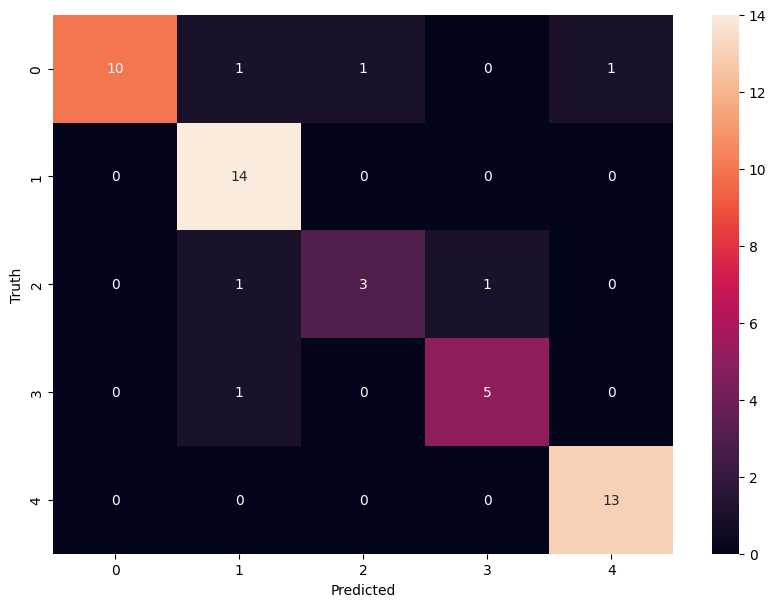

In [56]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Finally dumping our final model so as per gridsearch we get best score for logisitic regression with parameter c=1

In [57]:
Final_classifier=SVC(C=1,kernel="linear")
Final_classifier.fit(X_train,y_train)

SVC(C=1, kernel='linear')

In [58]:
import joblib

# Save the model
joblib.dump(Final_classifier, 'model.joblib')

['model.joblib']

In [59]:
Final_classifier.score(X_test,y_test)

0.8823529411764706

In [60]:
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [61]:
img = cv2.imread('/kaggle/input/sharapovaimg/sharapova1.jpg')
scalled_raw_img = cv2.resize(img, (32, 32))
img_har = w2d(img,'db1',5)
scalled_img_har = cv2.resize(img_har, (32, 32))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
scalled_img_gray = cv2.resize(img_gray, (32, 32))
combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1), scalled_img_gray.reshape(32*32,1)))
final_img = np.array(combined_img).reshape(5120).astype(float)

In [62]:
class_dict_convert={0:'lionel_messi',1:'maria_sharapova',2:'roger_federer',3:'serena_williams',4:'virat_kohli'}

In [63]:
final_img.shape

(5120,)

In [64]:
Final_classifier.predict([final_img])

array([1])

In [65]:
class_dict_convert[Final_classifier.predict([final_img])[0]]

'maria_sharapova'